# Task Introduction

**Part-of-speech** (POS) **tagging** is a popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context. In this assignment  we will ask you to perform POS tagging using neural architectures:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the baseline model, choose hyperparameters using the validation set
*   Evaluate your two best model
*   Analyze the errors of your model

Members:
* Iulian Zorila &emsp; 0001033291
* Davide Brescia 0001036867
* Daniele Marini &nbsp;0001060063



### To run without training
Instead of waiting for the training (around 1H with Grid Search, usign GPU) you can directly load all the trained models or the best ones.

First you need to run all the cells regarding the dataset preparation **ABOVE** the [Model section](#model_section).

Then you can choose to either:


*   [Load all models](#load_all)
*   [Load the two best models](#load_best)



# Imports

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from tqdm import tqdm
import itertools

from typing import List, Callable, Dict, Tuple
from collections import OrderedDict

!pip install patool
import patoolib
from urllib import request
import zipfile


import os
import sys
import time
import json

import gensim
import gensim.downloader as gloader

sns.set_theme()
plt.rcParams["figure.figsize"] = (15,6)

from google.colab import drive
drive.mount('/content/drive')

import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 3.6 MB/s eta 0:00:00
Mounted at /content/drive


# Manage Dataset

## Download and Extract the dataset

In [ ]:
#Getting the actual directory

print(f"Current work directory: {os.getcwd()}")
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

Current work directory: /content


In [ ]:
#Get the directory of the dataset

dataset_path = os.path.join(dataset_folder, "dependency_treebank.tar.gz")
print(f"Current dataset directory: {dataset_path}")

Current dataset directory: /content/Datasets/dependency_treebank.tar.gz


In [ ]:
def download_dataset(download_path: str, url: str):
  if not os.path.exists(download_path):
      print(f"Downloading {url.split('/')[-1]} ...")
      request.urlretrieve(url, download_path)
      print("Download complete!")

def extract_dataset(download_path: str, extract_path: str):
  print(f"Extracting {download_path.split('/')[-1]}... (it may take a while...)")
  with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print("Extraction completed!")

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
download_dataset(dataset_path, url)
extract_dataset(dataset_path, dataset_folder)

Download complete!
Extracting dependency_treebank.tar.gz... (it may take a while...)
Extraction completed!


## Inspect file structure
Files are named as such: "*wsj_0001.dp*".

They exhibit the following structure:


1.   A single file can be seen as document
2.   A **document** consists of multiple sentences (block of tokens),  separated by a double newline character `\n\n`.
3.   A **sentence** is made of different rows, separated by a single newline character `\n`. 
The row represents a **token** and its corresponding pos tag, divided by a tab character `\t`. 


In [ ]:
dataset_name = "dependency_treebank"
dataset_path = os.path.join(dataset_folder, dataset_name)

#List of all documents
file_names = os.listdir(dataset_path)

# Order by file number. File name example: "wsj_0001.dp, wsj_0002.dp, wsj_0003.dp ..."
file_names.sort(key=(lambda s: int(s.split("_")[1].split(".")[0])))
print(f"Total files: {len(file_names)}\n")

Total files: 199



In [ ]:
#Let's inspect the first file (wsj_0001.dp)

file_number = 0

file_to_inspect = file_names[file_number]
file_to_inspect_path = os.path.join(dataset_path, file_to_inspect)

print(f"Inspecting {file_to_inspect}")
pd.read_csv(file_to_inspect_path, sep='\t', header=None)

Inspecting wsj_0001.dp


,0,1,2
0,Pierre,NNP,2
1,Vinken,NNP,8
2,",",",",2
3,61,CD,5
4,years,NNS,6
5,old,JJ,2
6,",",",",2
7,will,MD,0
8,join,VB,8
9,the,DT,11


## Get DataFrame

We are not interested in maintaining the data structure in this way. In particular, **we want to make sure that each sentence** (considered as a list of strings) **has a list of tags associated with it**. In order to preserve the concept of a document we will associate each of these rows with the number of the document to which they belong so as to make the split easier.

For example:

`[[[word1, tag1],[word2, tag2],...]...] -> [[[word1, word2, ...],[tag1, tag2, ...]]...]`

In [ ]:
def get_dataframe(dataset_path: str, file_names: str) -> pd.DataFrame:
  df_rows = []
    
  # Iterate through documents (files)
  for i in tqdm(range(len(file_names))):
      file_path = os.path.join(dataset_path, file_names[i])
      
      with open(file_path, mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        sentences_str = text.split("\n\n")

        # Iterate through sentences
        for s in sentences_str:
          words, tags = [], []

          # Iterate through tokens
          for word in s.split("\n"):
            attributes = word.split("\t")

            # Last row is blank
            if len(attributes) > 2:
              
              # Get just the token and its pos tag
              words.append(attributes[0]) 
              tags.append(attributes[1])

          file_id = int(file_names[i].split('.')[0].split('_')[1])
          dataframe_row = {
                  "sentence": words,
                  "tag": tags,
                  "file_id": file_id,
                  }
          
          df_rows.append(dataframe_row)

  df = pd.DataFrame(df_rows)

  return df

In [ ]:
df = get_dataframe(dataset_path, file_names)

print(f'\n\nThe total number of sentences in the dataset is {df.shape[0]}')

#Let's visualize some data
df.head()

100%|██████████| 199/199 [00:00<00:00, 1991.79it/s]



The total number of sentences in the dataset is 3914


,sentence,tag,file_id
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, join, the, board, as, a, nonexecutive, director, Nov., 29, .]","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, IN, DT, JJ, NN, NNP, CD, .]",1
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V., ,, the, Dutch, publishing, group, .]","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, VBG, NN, .]",1
2,"[Rudolph, Agnew, ,, 55, years, old, and, former, chairman, of, Consolidated, Gold, Fields, PLC, ,, was, named, a, nonexecutive, director, of, this, British, industrial, conglomerate, .]","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP, NNP, NNP, NNP, ,, VBD, VBN, DT, JJ, NN, IN, DT, JJ, JJ, NN, .]",2
3,"[A, form, of, asbestos, once, used, to, make, Kent, cigarette, filters, has, caused, a, high, percentage, of, cancer, deaths, among, a, group, of, workers, exposed, to, it, more, than, 30, years, ago, ,, researchers, reported, .]","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS, VBZ, VBN, DT, JJ, NN, IN, NN, NNS, IN, DT, NN, IN, NNS, VBN, TO, PRP, RBR, IN, CD, NNS, IN, ,, NNS, VBD, .]",3
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, unusually, resilient, once, it, enters, the, lungs, ,, with, even, brief, exposures, to, it, causing, symptoms, that, show, up, decades, later, ,, researchers, said, .]","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, VBZ, DT, NNS, ,, IN, RB, JJ, NNS, TO, PRP, VBG, NNS, WDT, VBP, RP, NNS, JJ, ,, NNS, VBD, .]",3


### Show sentences distribution across documents and tag distribution

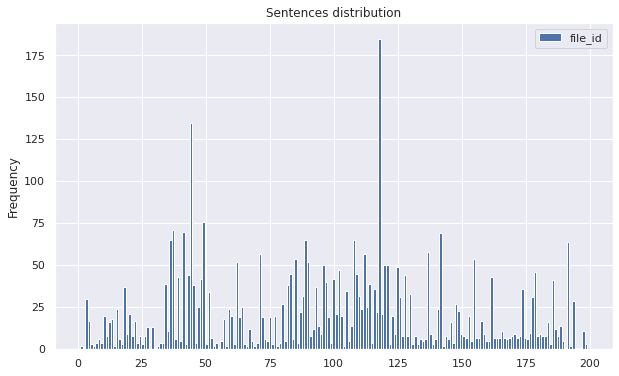


File with more than 75 sentences


file_id
44     135
49      76
118    185
dtype: int64

In [ ]:
df.plot.hist(by=['file_id'], bins=len(file_names), title='Sentences distribution', figsize=(10,6))
plt.show()

sentences_th = 75
print(f"\nFile with more than {sentences_th} sentences")
file_groups = df.groupby(['file_id']).size()
file_groups[file_groups > sentences_th]

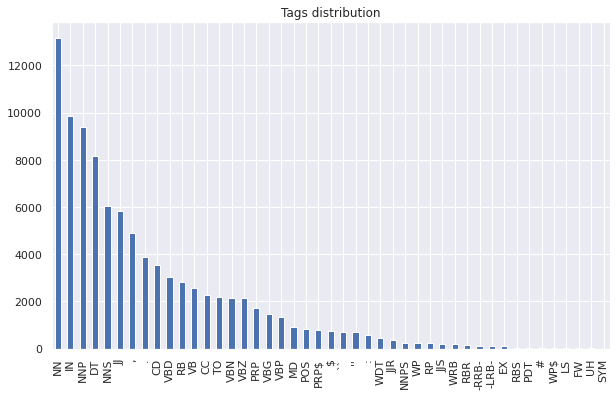

In [ ]:
df['tag'].explode().value_counts().plot(kind='bar', title="Tags distribution", figsize=(10,6))

# Data preprocessing and splitting

## Reproducibility

In [ ]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 42
set_reproducibility(seed)

## Lower Case

In order for as many words as possible that we have in the document corpus to match those in GloVe's pretrained embeddig layer, it is **necessary to make sure that the text is all in lower case**.

In [ ]:
def lower(sentence: List[str]) -> List[str]:
    """
    Transforms given text to lower case.
    """
    lower = []
    for word in sentence:
      lower.append(word.lower())
    return lower

In [ ]:
df['sentence'] = df['sentence'].apply(lower)

## Tag Tokenization

Since our neural network is unable to output the tag associated with the word in the form of a string it is necessary to **transform these into a single numeric value**. It is possible to do this through the use of the tokenizer.

In [ ]:
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(df['tag'])
df['ohe'] = tag_tokenizer.texts_to_sequences(df['tag'])

print("Tag encoding:\n")
tag_tokenizer.word_index

Tag encoding:



{'nn': 1,
 'in': 2,
 'nnp': 3,
 'dt': 4,
 'nns': 5,
 'jj': 6,
 ',': 7,
 '.': 8,
 'cd': 9,
 'vbd': 10,
 'rb': 11,
 'vb': 12,
 'cc': 13,
 'to': 14,
 'vbn': 15,
 'vbz': 16,
 'prp': 17,
 'vbg': 18,
 'vbp': 19,
 'md': 20,
 'pos': 21,
 'prp$': 22,
 '$': 23,
 '``': 24,
 "''": 25,
 ':': 26,
 'wdt': 27,
 'jjr': 28,
 'nnps': 29,
 'wp': 30,
 'rp': 31,
 'jjs': 32,
 'wrb': 33,
 'rbr': 34,
 '-rrb-': 35,
 '-lrb-': 36,
 'ex': 37,
 'rbs': 38,
 'pdt': 39,
 '#': 40,
 'wp$': 41,
 'ls': 42,
 'fw': 43,
 'uh': 44,
 'sym': 45}

In [ ]:
print("Total tags:", sum(tag_tokenizer.word_counts.values()))
print("\nTags distribution:\n")
sorted(tag_tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)

Total tags: 94084

Tags distribution:



[('nn', 13166),
 ('in', 9857),
 ('nnp', 9410),
 ('dt', 8165),
 ('nns', 6047),
 ('jj', 5834),
 (',', 4886),
 ('.', 3874),
 ('cd', 3546),
 ('vbd', 3043),
 ('rb', 2822),
 ('vb', 2554),
 ('cc', 2265),
 ('to', 2179),
 ('vbn', 2134),
 ('vbz', 2125),
 ('prp', 1716),
 ('vbg', 1460),
 ('vbp', 1321),
 ('md', 927),
 ('pos', 824),
 ('prp$', 766),
 ('$', 724),
 ('``', 712),
 ("''", 694),
 (':', 563),
 ('wdt', 445),
 ('jjr', 381),
 ('nnps', 244),
 ('wp', 241),
 ('rp', 216),
 ('jjs', 182),
 ('wrb', 178),
 ('rbr', 136),
 ('-rrb-', 126),
 ('-lrb-', 120),
 ('ex', 88),
 ('rbs', 35),
 ('pdt', 27),
 ('#', 16),
 ('wp$', 14),
 ('ls', 13),
 ('fw', 4),
 ('uh', 3),
 ('sym', 1)]

In [ ]:
element_to_inspect = 0

print(f'The {element_to_inspect} element has {len(df["tag"][element_to_inspect])} tag and {len(df["ohe"][element_to_inspect])} tag encodings')
print()

print('Tags and Encodings')
print(df["tag"][element_to_inspect])
print(df["ohe"][element_to_inspect])

The 0 element has 18 tag and 18 tag encodings

Tags and Encodings
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
[3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8]


In [ ]:
# Verify that every vectorize tag and sentece have the same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(df['sentence'], df['ohe'])]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Split Dataset

At this stage we will divide the dataset into three parts as follows:

* **Train Set**: documents 1-100
* **Validation Set**: documents 101-150 
* **Test Set**: documents 151-199

In [ ]:
train = df.loc[df['file_id'].isin(range(100))]
val = df.loc[df['file_id'].isin(range(100, 150))]
test = df.loc[df['file_id'].isin(range(150, 200))]

In [ ]:
print(f'The number of sentences in the training set is {train.shape[0]}')
print(f'The number of sentences in the valuation set is {val.shape[0]}')
print(f'The number of sentences in the test set is {test.shape[0]}')

The number of sentences in the training set is 1921
The number of sentences in the valuation set is 1332
The number of sentences in the test set is 661


## Embedding Phase

At this stage we will build the **tokenizer**, which will contain the following elements:
* `build_embedding_matrix` | _boolean_: if we want to build the embedding matrix or not.
* `embedding_dimension` | _int_: the dimension of the embedding matrix (number of features).
* `embedding_model_type` | _string_:  represent the name of the embedding model (we'll use GloVe).
* `embedding_matrix` | V x embedding_dimension matrix: a list of all words and their corresponding embeddings.
* `vocab_size` | _int_: represents the size of the vocabulary obtained by taking into account the words contained in the embedding.
* `oov_terms` | _list of strings_: represent all the words out of vocabolary found (useful for analysis purpuse).


For the **tokenizer** to work it is necessary to give in input: `build_embedding_matrix`, `embedding_dimension` and `embedding_model_type`



In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
import tensorflow as tf


class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int
        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = None
        self.embedding_matrix = None
        self.vocab = None
        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)
        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')
        self.vocab = self.tokenizer.word_index
        if self.build_embedding_matrix:
            print('Loading embedding model! It may take a while...')
            self.embedding_model = load_embedding_model(model_type=self.embedding_model_type,
                                                        embedding_dimension=self.embedding_dimension)
            
            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=list(self.vocab.keys()))

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab) + 1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms)
            print('Done!')


    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
            'oov_terms' : self.oov_terms,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

In [ ]:
tokenizer_args = {'oov_token': 'UNK'}
embedding_dimension = 50
tokenizer = KerasTokenizer(tokenizer_args = tokenizer_args,
                           build_embedding_matrix = True,
                           embedding_dimension = embedding_dimension,
                           embedding_model_type = "glove")
tokenizer.build_vocab(train['sentence'])
tokenizer_info = tokenizer.get_info()
print(f'Tokenizer info: {tokenizer_info}')

Fitting tokenizer...
Fit completed!
Loading embedding model! It may take a while...
[==================================================] 100.0% 66.0/66.0MB downloaded
Checking OOV terms...
Building the embedding matrix...


100%|██████████| 7305/7305 [00:00<00:00, 280639.61it/s]

Done!
Tokenizer info: {'build_embedding_matrix': True, 'embedding_dimension': 50, 'embedding_model_type': 'glove', 'embedding_matrix': (7306, 50), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7ff383fdedc0>, 'vocab_size': 7306, 'oov_terms': ['three-lawyer', 'training-wage', 'intellectual-property', 'pre-1933', '-rcb-', 'one-upsmanship', 'macmillan\\/mcgraw-hill', 'aslacton', 'c-90', 'teacher-cadet', '143.93', '30,841', 'test-prep', '70-a-share', '236.74', 'automotive-parts', '37-a-share', 'school-improvement', 'rate-sensitive', 'sometimes-exhausting', 'school-district', 'two-sevenths', 'equal-opportunity', 'solaia', 'limited-partnership', 'church-goers', 'chinchon', 'government-certified', 'index-related', 'UNK', 'bell-ringer', 'six-bottle', 'antitrust-law', 'delwin', '3,288,453', 'test-practice', 'rope-sight', '4,393,237', 'norwick', 'bald-faced', 'pianist-comedian', 'college-bowl', 'vinken', '-lrb-', 'uzi-model', 'family-planning', 'mouth-up', 'yen-s

## OOV Analysis

In [ ]:
oov_percentage = float(len(tokenizer_info['oov_terms'])) * 100 / tokenizer_info['vocab_size']

print(f"Some OOV terms: {[tokenizer_info['oov_terms'][i] for i in range(10)]}")
print(f"Total OOV terms: {len(tokenizer_info['oov_terms'])} ({oov_percentage:.2f}%)")

Some OOV terms: ['three-lawyer', 'training-wage', 'intellectual-property', 'pre-1933', '-rcb-', 'one-upsmanship', 'macmillan\\/mcgraw-hill', 'aslacton', 'c-90', 'teacher-cadet']
Total OOV terms: 354 (4.85%)


## Padding

The input of our network is fixed, so it is necessary to make sure that **all sentences given as input have a fixed length**. To solve this problem we have 2 ways of operation:
* Consider the sentence that contains the most words and apply padding according to the length of the latter.
* Consider the maximum length of most sentences ignoring exceptions and apply padding on this value.

It is wise to proceed with the second approach since there is a word that contains almost 250 terms in it and this would mean dealing with very long inputs. In fact, with the second approach we have that the recommended size is 56.

In [ ]:
def convert_text(texts, max_seq_length, tokenizer = None, tags = False):
    """
    Converts input text sequences using a given tokenizer

    :texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
    """

    if tags == False:
      texts = tokenizer.convert_tokens_to_ids(texts)
      
    text_ids = np.array([seq + [0] * (max_seq_length - len(seq)) for seq in texts])
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    return text_ids

In [ ]:
max_seq_length = int(np.quantile([len(seq) for seq in train['sentence']], 0.99))

# Train
x_train = convert_text(texts = train['sentence'], tokenizer = tokenizer, max_seq_length = max_seq_length)
y_train = convert_text(texts = train['ohe'], max_seq_length = max_seq_length, tags = True)
print(f"Max token sequence: {max_seq_length}")
print(f'X train shape: {len(x_train)}')
print(f'Y train shape: {len(y_train)}')

# Val
x_val = convert_text(texts = val['sentence'], tokenizer = tokenizer, max_seq_length = max_seq_length)
y_val = convert_text(texts = val['ohe'], max_seq_length = max_seq_length, tags = True)
print(f'X val shape: {len(x_val)}')
print(f'Y val shape: {len(y_val)}')

# Test
x_test = convert_text(texts = test['sentence'], tokenizer = tokenizer, max_seq_length = max_seq_length)
y_test = convert_text(texts = test['ohe'], max_seq_length = max_seq_length, tags = True)
print(f'X test shape: {len(x_test)}')
print(f'Y test shape: {len(y_test)}')

Max token sequence: 56
X train shape: 1921
Y train shape: 1921
X val shape: 1332
Y val shape: 1332
X test shape: 661
Y test shape: 661


<ipython-input-26-b3ec551947c5>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_ids = np.array([seq + [0] * (max_seq_length - len(seq)) for seq in texts])


In [ ]:
# Check if everything is fine

for i in range(len(x_train)):
  assert len(x_train[i]) == len(y_train[i])

for i in range(len(x_val)):
  assert len(x_val[i]) == len(y_val[i])

for i in range(len(x_test)):
  assert len(x_test[i]) == len(y_test[i])

print('[Debug] Padding succeeded correctly!')

[Debug] Padding succeeded correctly!


In [ ]:
# Show Padding

element = 0
print(f'x_train[{element}] is:\n{x_train[element]}\n')
print(f'y_train[{element}] is:\n{y_train[element]}\n')

print(f'The length of the token vector is {len(x_train[element])} \nThe length of the tag vector is {len(y_train[element])}')

x_train[0] is:
[3389 2282    2 1723   65  372    2   40 1346    3  190   24    7 1106
  261  694 2283    4    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

y_train[0] is:
[ 3  3  7  9  5  6  7 20 12  4  1  2  4  6  1  3  9  8  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]

The length of the token vector is 56 
The length of the tag vector is 56


##One hot encoding

In [ ]:
num_classes = len(tag_tokenizer.word_index) + 1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

print(f'Y train shape: {y_train.shape}')
print(f'Y test shape: {y_test.shape}')
print(f'Y val shape: {y_val.shape}')

Y train shape: (1921, 56, 46)
Y test shape: (661, 56, 46)
Y val shape: (1332, 56, 46)


## Choose proper tag for evaluation 

In [ ]:
all_classes = list(tag_tokenizer.word_index.keys())
all_tokens = list(tag_tokenizer.word_index.values())
punct_classes = [",", ".", ":", "``", "''", "$", "#", "sym", "-rrb-", "-lrb-"]
punct_tokens = [tag_tokenizer.word_index[p] for p in punct_classes]
allowed_classes = [word for word in tag_tokenizer.index_word.values() if word not in punct_classes]
allowed_tokens = [token for token in all_tokens if token not in punct_tokens]

print(f"All classes are: {all_classes}\n" +
      f"Their translation in token is: {all_tokens}\n\n" +
      f"Not Allow token (Punctuation) are: {punct_classes}\n" +
      f"Their translation in token is: {punct_tokens}\n\n" + 
      f"Classes without punctuation: {allowed_classes}\n" +
      f"Their translation in token is: {allowed_tokens}")

All classes are: ['nn', 'in', 'nnp', 'dt', 'nns', 'jj', ',', '.', 'cd', 'vbd', 'rb', 'vb', 'cc', 'to', 'vbn', 'vbz', 'prp', 'vbg', 'vbp', 'md', 'pos', 'prp$', '$', '``', "''", ':', 'wdt', 'jjr', 'nnps', 'wp', 'rp', 'jjs', 'wrb', 'rbr', '-rrb-', '-lrb-', 'ex', 'rbs', 'pdt', '#', 'wp$', 'ls', 'fw', 'uh', 'sym']
Their translation in token is: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Not Allow token (Punctuation) are: [',', '.', ':', '``', "''", '$', '#', 'sym', '-rrb-', '-lrb-']
Their translation in token is: [7, 8, 26, 24, 25, 23, 40, 45, 35, 36]

Classes without punctuation: ['nn', 'in', 'nnp', 'dt', 'nns', 'jj', 'cd', 'vbd', 'rb', 'vb', 'cc', 'to', 'vbn', 'vbz', 'prp', 'vbg', 'vbp', 'md', 'pos', 'prp$', 'wdt', 'jjr', 'nnps', 'wp', 'rp', 'jjs', 'wrb', 'rbr', 'ex', 'rbs', 'pdt', 'wp$', 'ls', 'fw', 'uh']
Their translation in token is: [1, 2, 3, 4, 5, 6, 9, 10

# Model <a name="model_section"></a>


## Simple Baseline test
Here we define: 
*   `display_history` function to plot accuracy and loss of the model.
*   The `Model` class which allows to create the different architectures specified in the assignment.
*   `emb_layer_params` dictionary which contains the parameters necessary for the embedding layer. Will be the same for all models.
*   `layers_params` dictionary which contains all the parameters which define the model structure (e.g. decide whether to use LSTM or GRU, multiple RNN layers and Dense layer at the end).

We run just a simple test with poorly selected units hyperparameter of the baseline model just to check performarmance.



In [ ]:
def display_history(history:tf.keras.callbacks.History):
    """
    Displays the history of the model, specifically the loss and accuracy.
    """
    # To get the actual dictionary
    hist_dict = history.history if  isinstance(history,tf.keras.callbacks.History) else history

    mse_training = hist_dict['loss']
    acc_training = hist_dict['acc']

    mse_val = hist_dict['val_loss']
    acc_val = hist_dict['val_acc']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [ ]:
class Model(tf.keras.Model):
  """
  Support class to manage the creation of the model
  """
  def __init__(self, out_dim: int, layers_params: Dict[str,object]):
    super().__init__()

    self.use_dense = "dense" in layers_params.keys()

    # Embedding layer
    self.emb_layer = layers.Embedding(**layers_params['embedding'])

    # Choose between GRU or LSTM
    rnn_layer = layers.LSTM if layers_params['use_lstm'] else layers.GRU

    self.bi_rnn_layers = [layers.Bidirectional(rnn_layer(**p)) for p in layers_params['rnn']]

    # Dense layers
    if self.use_dense:
      self.dense_layer = layers.Dense(**layers_params['dense'])

    # Classification layer
    self.last_dense = layers.Dense(out_dim, activation='softmax')

  def call(self, inputs):
    h = self.emb_layer(inputs)

    # Stack RNN layers
    for rnn_layer in self.bi_rnn_layers:
      h = rnn_layer(h)

    if self.use_dense:
      h = self.dense_layer(h)

    return self.last_dense(h)

  # Additional method to allow the correct printing of the network summary
  def build(self, shape, model_name):
    x = tf.keras.layers.Input(shape=(shape,))
    return tf.keras.Model(inputs=x, outputs=self.call(x), name=model_name)

def get_model_name(layers_params:Dict[str,object], base_name="model") -> str:
  """
  Get the model name, according to its structure
  :layers_params: dictionary of layers parameters
  :base_name: base of the name to start with

  :return
      A string representing the model name
  """
  # Identify whether the model uses LSTM or GRU
  version = "lstm" if layers_params['use_lstm'] else "gru"
  
  # Attach units per RNN layer in the name
  for p in layers_params['rnn']: version += f"_{p['units']}"

  dense_units = f"_dense_{layers_params['dense']['units']}" if "dense" in layers_params else ""

  version += dense_units

  return f"{base_name}_{version}"
  
# Define parameters of the embedding layer
emb_layer_params =  {
    'output_dim':embedding_dimension, 
    'input_dim':tokenizer_info['vocab_size'], 
    'input_length':max_seq_length, 
    'weights': tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix], 
    'trainable':False, 
    'mask_zero':False
    }

# Define other layers
layers_params = {
    'embedding': emb_layer_params, 
    'use_lstm':True,
    'rnn': [{'units':32, 'return_sequences':True}]
    }

out_dim = y_train.shape[2]
in_dim = max_seq_length

# Clear session
tf.keras.backend.clear_session()

# Create model and show summary
baseline_lstm = Model(out_dim, layers_params).build(in_dim, get_model_name(layers_params,"Baseline"))
baseline_lstm.summary()

Model: "Baseline_lstm_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding (Embedding)       (None, 56, 50)            365300    
                                                                 
 bidirectional (Bidirectiona  (None, 56, 64)           21248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 56, 46)            2990      
                                                                 
Total params: 389,538
Trainable params: 24,238
Non-trainable params: 365,300
_________________________________________________________________


### Compile and Train

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode = "min",
    patience=7,
    restore_best_weights=True
    )

baseline_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
batch_size = 64
epochs = 100

# Fit
history = baseline_lstm.fit(
  x_train, y_train, 
  batch_size=batch_size, 
  epochs=epochs, 
  validation_data=(x_val, y_val),
  callbacks=[early_stopping])

Epoch 1/100
31/31 [==============================] - 7s 93ms/step - loss: 3.2585 - acc: 0.5950 - val_loss: 2.3495 - val_acc: 0.6412
Epoch 2/100
31/31 [==============================] - 3s 90ms/step - loss: 1.6589 - acc: 0.6404 - val_loss: 1.3227 - val_acc: 0.6667
Epoch 3/100
31/31 [==============================] - 4s 129ms/step - loss: 1.2230 - acc: 0.6915 - val_loss: 1.1730 - val_acc: 0.7017
Epoch 4/100
31/31 [==============================] - 2s 62ms/step - loss: 1.0961 - acc: 0.7337 - val_loss: 1.0675 - val_acc: 0.7443
Epoch 5/100
31/31 [==============================] - 2s 61ms/step - loss: 0.9903 - acc: 0.7626 - val_loss: 0.9711 - val_acc: 0.7595
Epoch 6/100
31/31 [==============================] - 2s 61ms/step - loss: 0.8976 - acc: 0.7770 - val_loss: 0.8898 - val_acc: 0.7717
Epoch 7/100
31/31 [==============================] - 2s 63ms/step - loss: 0.8193 - acc: 0.7903 - val_loss: 0.8212 - val_acc: 0.7825
Epoch 8/100
31/31 [==============================] - 2s 62ms/step - loss: 0

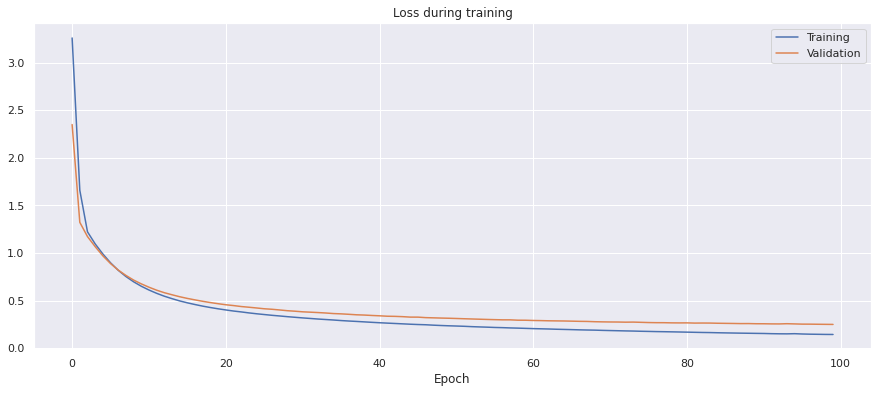

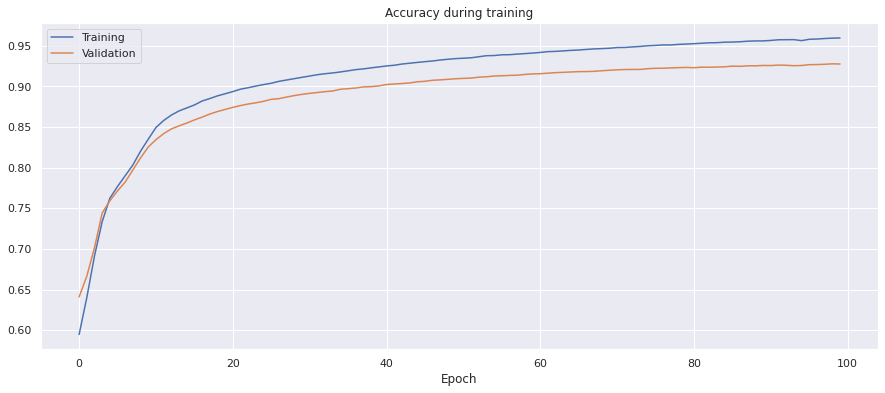

In [ ]:
display_history(history)

In [ ]:
y_pred = baseline_lstm.predict([x_test]).argmax(-1).flatten()
y_test_flatten = y_test.argmax(-1).flatten()

print("F1 score: {}".format(f1_score(y_test_flatten, y_pred, labels=allowed_tokens, average='macro', zero_division=0)))

21/21 [==============================] - 0s 13ms/step
F1 score: 0.6350883038046798


## Grid search
The goal is to evaluate different models for each architecture, according to multiple combinations of layers units.

To be able to plot the results at the end across different architectures, the first number of units values to try for the first RNN layer is the same, i.e. `[32,64,128,256,512]`, while the secondary ones can change (e.g. addition of another LSTM layer or dense layer at the end).

We define all the needed functions for the `grid_search_nn`, along with `architectures` dictionary, which will contain a list of models for each architecture.



### Function definition

In [ ]:
def get_train_wights(model:tf.keras.Model) -> int:
  """
  Get the trainable weights of the model

  :return
      An integer representing the number of trainable parameters
  """
  return int(np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights]))

def set_configuration(use_dense: bool, layers_params:Dict[int,object], comb: Tuple[int]):
  """
  Sets the units configuration of the dense and rnn layers in the layers_params dictionary according
  to the comb variable.

  :layers_params: dictionary of layers parameters
  :comb: tuple containing all the possible combinations between layers units
  """
  # Reserve the last number in the combination for dense units
  if use_dense:
    for i in range(len(comb)-1): 
      layers_params["rnn"][i]['units'] = comb[i]
      layers_params["dense"]["units"] = comb[i+1]
  # Otherwise set just the RNN units
  else:
    for i in range(len(comb)): layers_params["rnn"][i]['units'] = comb[i]

def get_combs(layers_units: Dict[str,List[int]], use_dense:bool) -> Tuple[int,List[Tuple[int]]]:
  """
  Get the combinations between layers units, given the layers_units dictionary.

  :layers_units: dictionary of layers units to combine
  :use_dense: specifies whether the dense layer is used or not

  :return
    :n_sub_models: an integer representing the number of sub models to train for each rnn units value
    :combs: a tuple containing all the possible combinations between layers units
  """
  n_sub_models = 1
  # Get number of submodels for each combination with the first RNN layer units
  for i in range(1,len(layers_units["rnn"])): n_sub_models*=len(layers_units["rnn"][i])
  if use_dense: n_sub_models*=len(layers_units["dense"])

  # Get the combinations of parameters
  l = [*layers_units["rnn"], layers_units["dense"]] if use_dense else layers_units["rnn"]
  combs = list(itertools.product(*l))

  return n_sub_models,combs
      
# Create multiple models with different number of neurons
def grid_search_nn(layers_units: Dict[str,List[int]], 
                   layers_params: Dict[int,object], 
                   callbacks: List[tf.keras.callbacks.Callback], 
                   data:Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray], 
                   base_model_name:str) -> List[tf.keras.Model]:
  """
  Grid search to test multiple models, given a layers_units dictionary of different units combinations and the layers_params dictionary
  necessary for the creation of the model.

  :layers_units: dictionary of layers units to combine
  :layers_params: dictionary of layers parameters to create the model
  :callbacks: list of callbacks to use
  :data: tuple of arrays to provide the training, validation and test data
  :base_model_name: string which specifies the base name of the model (e.g. "Baseline" or "Variation")

  :return
    :models_list: A list where each element is a dictionary containing the model, its history, the f1-score on the test set and the number of trained epochs
  """

  # Initialization
  models_list = []
  sub_models = []

  # Unpack data for training, validation and test
  x_train, y_train, x_val, y_val, x_test, y_test = data
  total_time = 0

  # Define input and output dimension
  in_dim = len(x_train[0])
  out_dim = y_train.shape[2]

  # Check whether the units combinations to test includes the dense layer
  use_dense = "dense" in layers_units.keys()
  
  # Get number of sub models for each rnn units value and the combinations
  n_sub_models, combs = get_combs(layers_units, use_dense)
  print("Units combinations to evaluate:", combs)

  for i in range(len(combs)): 
    # Set parameters to layers_params from the combination
    set_configuration(use_dense, layers_params, combs[i])
    
    start = time.time()

    # Create
    model = Model(out_dim, layers_params).build(in_dim, get_model_name(layers_params, base_model_name))
    
    # Compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    trainable_params = get_train_wights(model)

    print(f"\n","-"*60)
    print(f"\nTraining model {model.name} ({trainable_params:,} params) ...\n")

    batch_size = 64
    epochs = 100

    # Fit
    history = model.fit(
        x_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val, y_val),
        callbacks=callbacks)
    
    # Evaluate
    y_pred = model.predict([x_test]).argmax(-1).flatten()
    y_test_flatten = y_test.argmax(-1).flatten()

    # Compute f1 score macro
    f1 = f1_score(y_test_flatten, y_pred, labels=allowed_tokens, average='macro', zero_division=0)
    end = time.time()
    total_time += end-start

    print(f"\n\nF1 score: {f1:.4f} \nElapsed: {end-start:.2f}s")
    
    # Get the true number of trained epochs
    eps_trained = epochs if early_stopping.stopped_epoch == 0 else early_stopping.stopped_epoch
    sub_models.append({'model':model,'history':history,'f1_score':f1, 'eps_trained':eps_trained})

    # Keep just the best sub model 
    # e.g. First RNN layer has (64,128) units values
    #      Second layer has (128,256,512) units values
    #      The number of sub models will be 3 for each units value in the first layer
    if (i + 1) % n_sub_models == 0:
      best_sub_model = max(sub_models, key=lambda d: d["f1_score"])
      sub_models.clear()
    
      models_list.append(best_sub_model)

  print(f"\nTotal elapsed: {total_time:.2f}s")

  return models_list

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode = "min",
    patience=7,
    restore_best_weights=True
    )

data=[x_train, y_train, x_val, y_val, x_test, y_test] 

architectures = {"Baseline_lstm":[],"Variation_gru":[],"Double_lstm":[],"Variation_lstm_dense":[]}

### Baseline LSTM
Run `grid_search_nn` for the baseline model

In [ ]:
layers_params = {
    'embedding': emb_layer_params, 
    'use_lstm':True,
    'rnn': [{'units':32, 'return_sequences':True}],
    }
  
layers_units = {"rnn":[[32,64,128,256,512]]}

architectures["Baseline_lstm"] = grid_search_nn(layers_units, layers_params, [early_stopping], data, "baseline")

Units combinations to evaluate: [(32,), (64,), (128,), (256,), (512,)]

 ------------------------------------------------------------

Training model baseline_lstm_32 (24,238 params) ...

Epoch 1/100
31/31 [==============================] - 4s 39ms/step - loss: 3.4374 - acc: 0.5494 - val_loss: 2.6429 - val_acc: 0.6386
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 1.7258 - acc: 0.6446 - val_loss: 1.3336 - val_acc: 0.6807
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 1.2348 - acc: 0.6930 - val_loss: 1.1847 - val_acc: 0.6987
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 1.1177 - acc: 0.7195 - val_loss: 1.0931 - val_acc: 0.7355
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 1.0239 - acc: 0.7550 - val_loss: 1.0057 - val_acc: 0.7600
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 0.9342 - acc: 0.7753 - val_loss: 0.9225 - val_acc: 0.7725
Epoch 7/100
31/31 [=

### Variation GRU
Run `grid_search_nn` for the GRU variation. The `layers_units` dictionary remains unchanged, since we are just switching from LSTM to GRU.

In [ ]:
layers_params["use_lstm"] = False

architectures["Variation_gru"] = grid_search_nn(layers_units, layers_params, [early_stopping], data, "variation")

Units combinations to evaluate: [(32,), (64,), (128,), (256,), (512,)]

 ------------------------------------------------------------

Training model variation_gru_32 (19,118 params) ...

Epoch 1/100
31/31 [==============================] - 4s 37ms/step - loss: 3.5562 - acc: 0.5830 - val_loss: 3.1051 - val_acc: 0.6547
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 2.0807 - acc: 0.6659 - val_loss: 1.2310 - val_acc: 0.6733
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 1.0899 - acc: 0.7175 - val_loss: 1.0228 - val_acc: 0.7450
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 0.9302 - acc: 0.7731 - val_loss: 0.8963 - val_acc: 0.7763
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.8128 - acc: 0.7959 - val_loss: 0.7987 - val_acc: 0.7936
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 0.7208 - acc: 0.8169 - val_loss: 0.7238 - val_acc: 0.8128
Epoch 7/100
31/31 [=

### Double LSTM
Run `grid_search_nn` for the double LSTM variation. `layers_params` will now contain the parameters for two LSTM layers.

In [ ]:
layers_params["use_lstm"] = True
layers_params["rnn"] = [{'units':32, 'return_sequences':True},{'units':32, 'return_sequences':True}]
  
layers_units = {"rnn":[[32,64,128,256,512],[32,64,128,256,512]]}

architectures["Double_lstm"] = grid_search_nn(layers_units, layers_params, [early_stopping], data, "double")

Units combinations to evaluate: [(32, 32), (32, 64), (32, 128), (32, 256), (32, 512), (64, 32), (64, 64), (64, 128), (64, 256), (64, 512), (128, 32), (128, 64), (128, 128), (128, 256), (128, 512), (256, 32), (256, 64), (256, 128), (256, 256), (256, 512), (512, 32), (512, 64), (512, 128), (512, 256), (512, 512)]

 ------------------------------------------------------------

Training model double_lstm_32_32 (49,070 params) ...

Epoch 1/100
31/31 [==============================] - 12s 113ms/step - loss: 2.7061 - acc: 0.5712 - val_loss: 1.5109 - val_acc: 0.6137
Epoch 2/100
31/31 [==============================] - 1s 37ms/step - loss: 1.3506 - acc: 0.6330 - val_loss: 1.2743 - val_acc: 0.6481
Epoch 3/100
31/31 [==============================] - 1s 42ms/step - loss: 1.2294 - acc: 0.6550 - val_loss: 1.2064 - val_acc: 0.6570
Epoch 4/100
31/31 [==============================] - 1s 35ms/step - loss: 1.1605 - acc: 0.6792 - val_loss: 1.1313 - val_acc: 0.6932
Epoch 5/100
31/31 [====================

### Variation LSTM-Dense
Run `grid_search_nn` for the double LSTM and dense layers variation

In [ ]:
layers_params['rnn'] = [{'units':32, 'return_sequences':True}]
layers_params['dense'] = {'units':128, 'activation':'relu'}
  
layers_units = {"rnn":[[32,64,128,256,512]], "dense":[128,256,512,1024,2048]}

architectures["Variation_lstm_dense"] = grid_search_nn(layers_units, layers_params, [early_stopping], data, "variation")

Units combinations to evaluate: [(32, 128), (32, 256), (32, 512), (32, 1024), (32, 2048), (64, 128), (64, 256), (64, 512), (64, 1024), (64, 2048), (128, 128), (128, 256), (128, 512), (128, 1024), (128, 2048), (256, 128), (256, 256), (256, 512), (256, 1024), (256, 2048), (512, 128), (512, 256), (512, 512), (512, 1024), (512, 2048)]

 ------------------------------------------------------------

Training model variation_lstm_32_dense_128 (35,502 params) ...

Epoch 1/100
31/31 [==============================] - 5s 42ms/step - loss: 2.8991 - acc: 0.5923 - val_loss: 1.4125 - val_acc: 0.6193
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 1.2377 - acc: 0.6656 - val_loss: 1.1518 - val_acc: 0.7043
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 1.0532 - acc: 0.7298 - val_loss: 0.9866 - val_acc: 0.7506
Epoch 4/100
31/31 [==============================] - 0s 13ms/step - loss: 0.8784 - acc: 0.7702 - val_loss: 0.8316 - val_acc: 0.7766
Epoch 5/100

### Plot Differences
Plot the F1 score against the number of units tested in the first RNN layer for the 4 obtained architectures.

The **Double LSTM** and **LSTM-dense** variations will have just the best sub model for each units value in the first RNN layer: 

e.g. 1st layer has these units combinations `[32,64,128,256,512]` and second LSTM layer could have `[32,64,128,256,512]`, therefore we would obtain `(32,32), (32,64), (32,128), (32,256), (32,512)`, but we keep just the best sub model among these combinations, say `(32,128)` and same goes for the next ones `(64,32), (64,64), (64,128), ...` and so on.

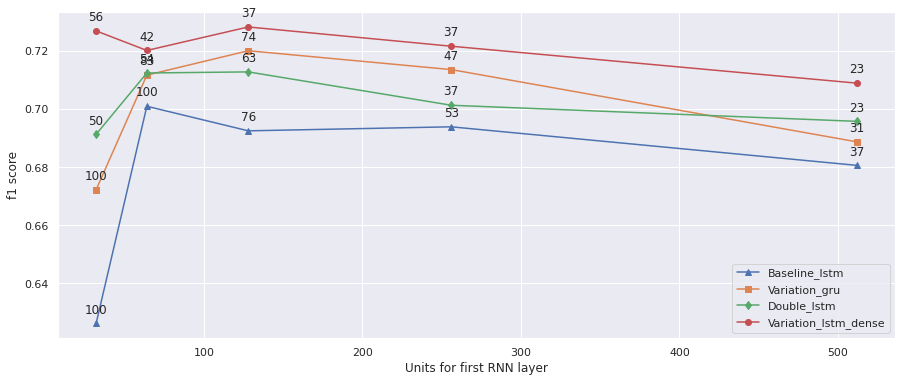

In [ ]:
def plot_f1(architectures:Dict[str,List[Dict[str,object]]], first_rnn_units:List[int]):
  """
  Plots the f1 score against the number of units in the first layer

  :architectures: contains all the tested architectures with every model combination
  :first_rnn_units: contains the total number of tested units for the first layer 
  """
  markers = ['^','s','d','o']
  for models_list,m in zip(architectures.values(),markers):
    plt.plot(first_rnn_units,[v['f1_score'] for v in models_list], marker=m)
    plt.xlabel("Units for first RNN layer")
    plt.ylabel("f1 score")

    for y,x in zip(models_list, first_rnn_units):
      plt.annotate(y['eps_trained'], 
                  (x, y['f1_score']), textcoords="offset points", xytext=(0,10), ha='center')

  plt.legend(labels=list(architectures.keys()))
  plt.show()

plot_f1(architectures, layers_units["rnn"][0])

### Obtain the best model
Get the *n=2* models with the maximum F1 score for each architecture, then get the two best ones.

The variations with **LSTM + dense** result to be better than others, simply because the second layer has 2048 units, which allows to have more expressive power.

Otherwise, if less units were used for the dense layer, the GRU variation would have been a good candidate.

In [ ]:
def get_first_n_best(architectures:Dict[str,List[Dict[str,object]]], n:int=2) -> List[Dict[str,object]]:
  """
  Get the first n best models in the given architectures dictionary.

  :architectures: contains all the tested architectures with every model combination
  :n: the number of best models to retrieve

  :return
    :best_n: list of best models
  """
  # Add all the models to a single list
  all_models_list = []
  for models in architectures.values(): all_models_list.extend(models)
  best_n = []

  # Extract the best, then pop it from the list
  for i in range(n):
    best_idx = max(range(len(all_models_list)), key=lambda i: all_models_list[i]["f1_score"])
    best_model = all_models_list.pop(best_idx)
    best_n.append(best_model)

  del(all_models_list)

  return best_n

In [ ]:
# For every architecture, get the best model
print("Best models for each architecture:\n")
for k in architectures.keys():
  best = max(architectures[k], key=lambda d: d["f1_score"])
  print("%s:\t %s\t f1_score: %.4f" % (k, best["model"].name, best["f1_score"]))

# Get first and second best model
first_best, second_best = get_first_n_best(architectures, n=2)

print("\nFirst two best models:\n")
print("First best:\t %s\t f1_score: %.4f" % (first_best["model"].name, first_best["f1_score"]))
print("Second best:\t %s\t f1_score: %.4f" % (second_best["model"].name, second_best["f1_score"]))

Best models for each architecture:

Baseline_lstm:	 baseline_lstm_64	 f1_score: 0.7010
Variation_gru:	 variation_gru_128	 f1_score: 0.7202
Double_lstm:	 double_lstm_128_128	 f1_score: 0.7129
Variation_lstm_dense:	 variation_lstm_128_dense_2048	 f1_score: 0.7283

First two best models:

First best:	 variation_lstm_128_dense_2048	 f1_score: 0.7283
Second best:	 variation_lstm_32_dense_2048	 f1_score: 0.7270


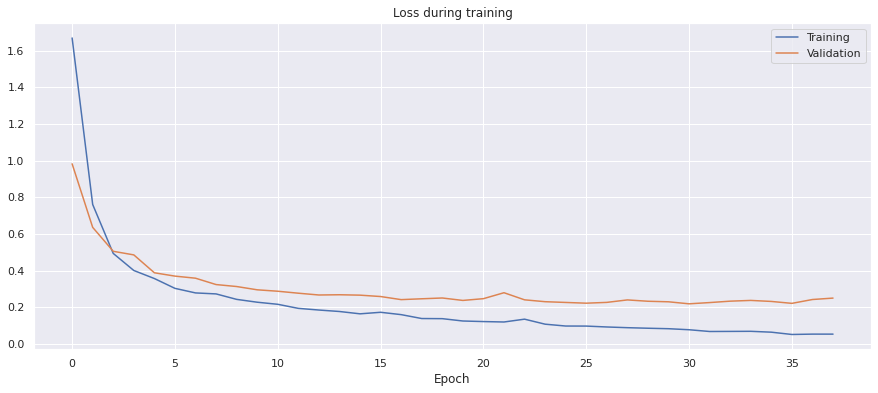

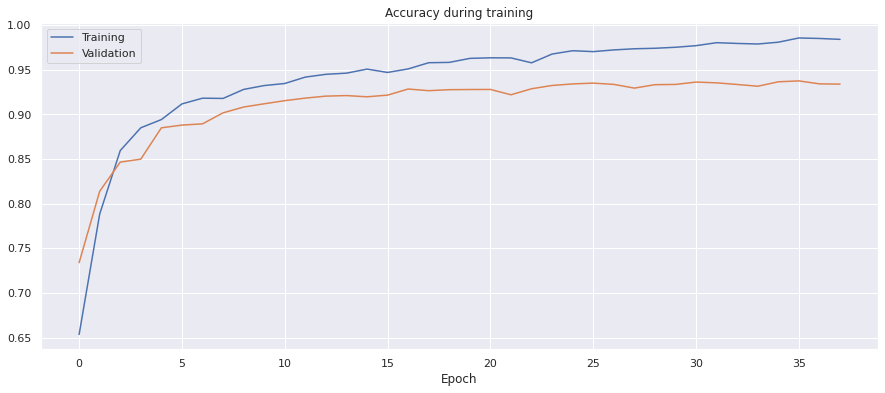

In [ ]:
display_history(first_best["history"])

### Save Models

In [ ]:
def save_load_dict(file_path:str, dict_data: Dict[str,object] = None, save=True) -> Dict[str,object]:
  """
  Saves or loads the dictionary in a json format

  :return
    :res: contains the loaded dictionary when reading from file
  """
  if save:
    mode = 'w'
    action = lambda f: f.write(json.dumps(dict_data))
  else:
    mode = 'r'
    action = lambda f: json.load(f)
  
  with open(file_path, mode) as f:
    res = action(f)

  return res

def save_results(architectures:Dict[str,List[Dict[str,object]]], directory:str):
  """
  Saves all the models contained in the architectures dictionary, in the specified directory. Along with their history
  and F1 score on the test set.

  :architectures: contains all the tested architectures with every model combination
  :directory: string containing the directory to save the models
  """
  for k in architectures.keys():
    architecture_dir = os.path.join(directory,k)

    # Check if architecture dir exists
    if not os.path.exists(architecture_dir): os.makedirs(architecture_dir)
    print(f"\nProcessing architecture {k} ...\n")
    for m_dict in architectures[k]:
      model_dir = os.path.join(architecture_dir,m_dict["model"].name)

      # Check if model dir inside architecture dir exists
      if not os.path.exists(model_dir): os.makedirs(model_dir)
      print(f"\n\tSaving model {m_dict['model'].name} ...")
      m_dict["model"].save(model_dir)
      
      # Save also history and f1 score
      hist_f1_dir = os.path.join(model_dir,"hist_f1.json")
      dict_hist_f1 = {"history":m_dict["history"].history, "f1_score":m_dict["f1_score"]}
      save_load_dict(hist_f1_dir, dict_hist_f1, save=True)

  print("\n\nSave complete!")

In [ ]:
save_results(architectures, "/content/drive/MyDrive/NLP_postag_model/All_Models")


Processing architecture Baseline_lstm ...


	Saving model baseline_lstm_32 ...



	Saving model baseline_lstm_64 ...



	Saving model baseline_lstm_128 ...



	Saving model baseline_lstm_256 ...



	Saving model baseline_lstm_512 ...



Processing architecture Variation_gru ...


	Saving model variation_gru_32 ...



	Saving model variation_gru_64 ...



	Saving model variation_gru_128 ...



	Saving model variation_gru_256 ...



	Saving model variation_gru_512 ...



Processing architecture Double_lstm ...


	Saving model double_lstm_32_512 ...



	Saving model double_lstm_64_256 ...



	Saving model double_lstm_128_128 ...



	Saving model double_lstm_256_256 ...



	Saving model double_lstm_512_512 ...



Processing architecture Variation_lstm_dense ...


	Saving model variation_lstm_32_dense_2048 ...



	Saving model variation_lstm_64_dense_2048 ...



	Saving model variation_lstm_128_dense_2048 ...



	Saving model variation_lstm_256_dense_512 ...



	Saving model variation_lstm_512_dense_2048 ...




Save complete!


# Load Models 

### Load all results (Optional) <a name="load_all"></a>
For debugging and test purposes we loaded all models to run further experiments without training again

In [ ]:
def download_extract_results(folder: str = "Results") -> str:
  """
  Downloads the results in the specified folder. The latter contains all trained models.

  :folder: output folder to save results

  :return
    The name of the extracted file
  """
  url = "https://www.dropbox.com/s/uviz36uzekngl5d/All_Models.rar?dl=1"
  if not os.path.exists(folder): os.mkdir(folder)

  file_name = os.path.basename(url).split('?')[0] # All_models.rar
  download_path = os.path.join(folder,file_name)

  # Download models
  print("Downloading the results ...\n")
  request.urlretrieve(url, download_path)
  print("Extracting the results ...\n")
  patoolib.extract_archive(download_path, outdir=folder)
  print("\nSuccess!")

  return file_name.split('.')[0] # All_models

def load_results(output_folder: str = "Results", 
                 hist_f1_file: str = "hist_f1.json") -> Dict[str,List[Dict[str,object]]]:
  """
  Loads the results saved in previous experiments, in particular, loads all saved models with their history
  and F1 score on the test set.

  :path: the path where all architectures are stored
  :hist_f1_file: name of the json file where the history and f1 score are stored 

  :return
    :architectures: dictionary containing all the architectures with their respective models
  """
  # Download and extract
  folder_name = download_extract_results(output_folder)

  path = os.path.join(output_folder, folder_name)
  architectures = {}

  # Get child directories
  arch_dirs = next(os.walk(path))[1]

  # Scan architectures directories
  for d in arch_dirs:
    print(f"\nProcessing architecture {d} ...\n")
    arch = d
    architectures[arch] = []

    d = os.path.join(path,d)
    models_dirs = next(os.walk(d))[1]

    # Load each model belonging to the architecture
    for model_dir in models_dirs:

      # Load model
      print(f"\n\tLoading model {model_dir} ...")
      model_dir = os.path.join(d,model_dir)
      model = tf.keras.models.load_model(model_dir)
    
      # Get its history and F1 score on the test set
      hist_f1_dict = save_load_dict(os.path.join(model_dir, hist_f1_file), save=False)
      eps_trained = len(hist_f1_dict["history"]["val_loss"])
      
      architectures[arch].append({'model':model,'history':hist_f1_dict["history"],
                                  'f1_score':hist_f1_dict["f1_score"], 'eps_trained':eps_trained})
      
  print("\n\nLoad complete!")
  return architectures

In [ ]:
architectures = load_results()
first_best, second_best = get_first_n_best(architectures,n=2)

print("\nFirst two best models:\n")
print("First best:\t %s\t f1_score: %.4f" % (first_best["model"].name, first_best["f1_score"]))
print("Second best:\t %s\t f1_score: %.4f" % (second_best["model"].name, second_best["f1_score"]))


Extracting the results ...

patool: Extracting Results/All_Models.rar ...
patool: running /usr/bin/unrar x -- /content/Results/All_Models.rar
patool:     with cwd='Results'
patool: ... Results/All_Models.rar extracted to `Results'.

Success!

Processing architecture Double_lstm ...


	Loading model double_lstm_512_512 ...

	Loading model double_lstm_64_256 ...

	Loading model double_lstm_32_512 ...

	Loading model double_lstm_256_256 ...

	Loading model double_lstm_128_128 ...

Processing architecture Variation_gru ...


	Loading model variation_gru_32 ...

	Loading model variation_gru_256 ...

	Loading model variation_gru_128 ...

	Loading model variation_gru_512 ...

	Loading model variation_gru_64 ...

Processing architecture Baseline_lstm ...


	Loading model baseline_lstm_128 ...

	Loading model baseline_lstm_512 ...

	Loading model baseline_lstm_256 ...

	Loading model baseline_lstm_32 ...

	Loading model baseline_lstm_64 ...

Processing architecture Variation_lstm_dense ...


	

### Load just the two best models from github repository <a name="load_best"></a>

In [ ]:
def load_best(urls:List[str]=
              ["https://github.com/iulianzorila/Pos-Tagging/raw/main/variation_lstm_128_dense_2048.zip",
               "https://github.com/iulianzorila/Pos-Tagging/raw/main/variation_lstm_32_dense_2048.zip"]) -> List[tf.keras.Model]:
  """
  Loads the best models from the github repository

  :urls: list of strings containing the links to the models

  :return
    :best_models: list of keras models 
  """
  
  best_models = [] 
  path = "best_models"
  if not os.path.exists(path): os.mkdir(path)

  for url in urls:
    file_name = os.path.basename(url)
    file_path = os.path.join(path,file_name)

    # Download
    request.urlretrieve(url, file_path)

    # Extract
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
      zip_ref.extractall(path)
    
    model_path = os.path.join(path,file_name.split('.')[0])

    # Load models
    print("Loading model {} ...".format(file_name.split('.')[0]))
    best_models.append(tf.keras.models.load_model(model_path))

  return best_models

model1, model2 = load_best()
print("\nFirst best:", model1.name)
print("Second best:", model2.name)

Loading model variation_lstm_128_dense_2048 ...
Loading model variation_lstm_32_dense_2048 ...

First best: variation_lstm_128_dense_2048
Second best: variation_lstm_32_dense_2048


# Evaluation Phase

## Visualize Data Distribution

As we can see from the distributions, classes are missing in the test and validation

In [ ]:
def plot_dists(dist1, dist2 = None, 
               tokens = None, class_names = None, 
               title = None, y_title = None,
               dist1_title=None, dist2_title = None):

  fig = plt.figure(figsize = (22, 5))
  
  if dist2:
    plt.bar(np.arange(len(tokens)) - 0.2, dist1, 0.4, label = dist1_title, color='green')
    plt.bar(np.arange(len(tokens)) + 0.2, dist2, 0.4, label = dist2_title, color='red')

  else:
    plt.bar(np.arange(len(tokens)), dist1, 0.6, label = dist1_title, color='blue')

  if class_names:
    plt.xticks(np.arange(len(tokens)), class_names)
  plt.xlabel("Labels")
  plt.ylabel(y_title)
  plt.title(title)
  plt.legend()
  plt.show()

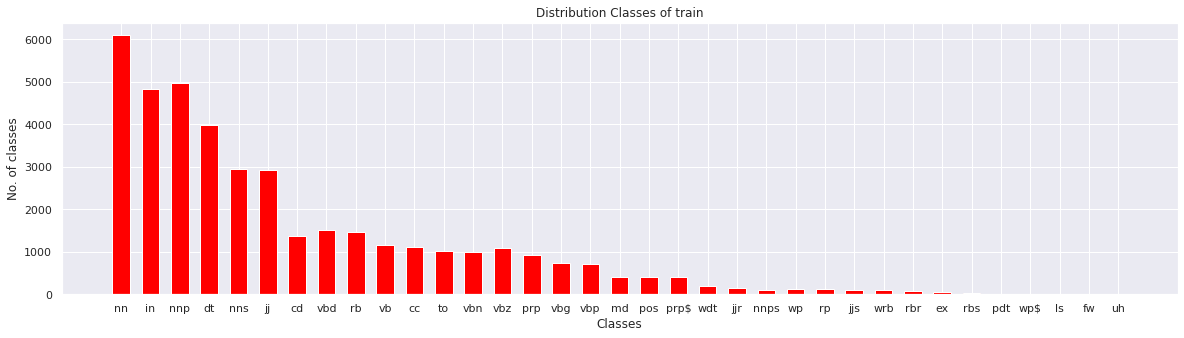

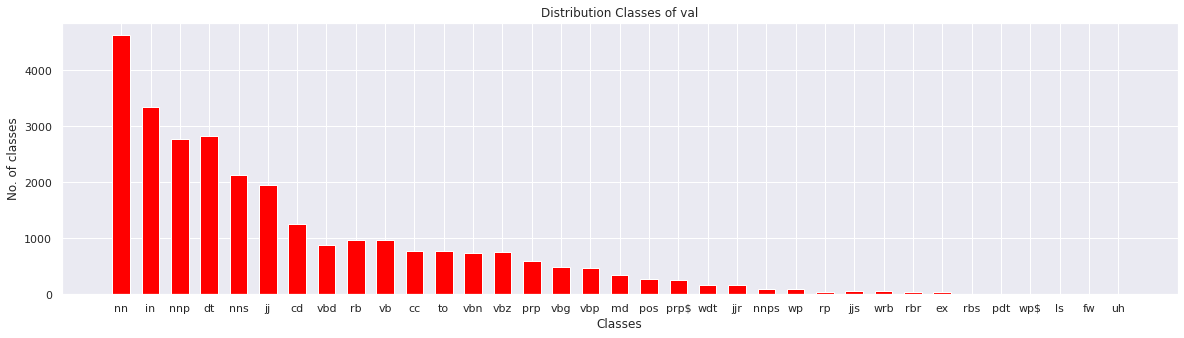

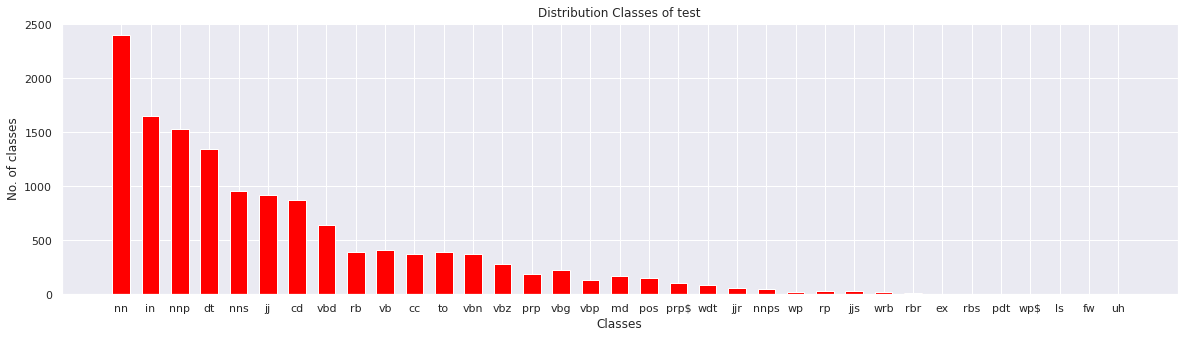

In [ ]:
from collections import Counter

def plot_class_distribution(values, tokens, class_names = None, set_name = ""):

  classes = [x for x in values.flatten() if x in tokens]
  classes_count = [classes.count(i) for i in tokens]
  
  fig = plt.figure(figsize = (20, 5))

  if not class_names:
    plt.bar(tokens, classes_count, color ='red', width = 0.6)
    plt.xticks(tokens)
  else:
    plt.bar(class_names, classes_count, color ='red', width = 0.6)

  plt.xlabel("Classes")
  plt.ylabel("No. of classes")
  plt.title("Distribution Classes of " + set_name)
  plt.show()

plot_class_distribution(y_train.argmax(-1), allowed_tokens, allowed_classes, set_name = "train")
plot_class_distribution(y_val.argmax(-1), allowed_tokens, allowed_classes, set_name = "val")
plot_class_distribution(y_test.argmax(-1), allowed_tokens, allowed_classes, set_name = "test")


## Get Prediction

In [ ]:
#Predict the values and remove one hot encoding
#0 -> best model
#1 -> 2nd best model
y_preds = [model1.predict([x_test]).argmax(-1), model2.predict([x_test]).argmax(-1)]
y_test = y_test.argmax(-1)

21/21 [==============================] - 3s 76ms/step


In [ ]:
tokenized_text = tokenizer.tokenizer.sequences_to_texts(x_test)
results = [tag_tokenizer.sequences_to_texts(y_preds[0]), tag_tokenizer.sequences_to_texts(y_preds[1])]

## Print Scores

To get an **initial idea of the performance of the two models**, it was helpful to print the **classification report**. As can be seen from the following cells, the f1 (macro) score without considering punctuation is close to **0.73** for both models with `zero_division=0`. If we consider this metric for all labels (thus including punctuation) the value goes up slightly. Moreover, we can say that the **performance of the two models is very similar**. 

We generally obtain **good result** for the following classes:

* in - Preposition or subordinating conjunction
* dt - Determiner
* cc - Coordinating conjunction
* to - to
* prp - Personal pronoun
* md - Modal
* pos - Possessive ending
* prp$ - Possessive pronoun
* wdt - Wh-determiner

Specifically, among the **worst performing classes** are: 

* jj - Adjective
* vbn - Verb, past participle
* vbg - Verb, gerund or present participle
* rp - Particle

In addition, other classes **have too few examples and having poor performance**:

* nnps - Proper noun, plural (3 elements)
* rbr - Adverb, comparative (8 elements)
* ls - List item marker (3 elements)

There are also **tags that performed well but have few examples** in the test set (so this could be a case):

* ex - Existential there (5 elements)
* rbs - Adverb, superlative (3 elements)
* wp$ - Possessive wh-pronoun (4 elements)

In conclusion, we can observe that some of the values that appear in training and validation sets do **not appear in the test set**:

* pdt - Predeterminer
* fw - Foreign word
* uh - Interjection


### Classification Report - 1st best Model

In [ ]:
print("F1 score:", f1_score(y_preds[0].flatten(), y_test.flatten(), labels = allowed_tokens, zero_division = 0, average='macro'),"\n")
print(classification_report(y_preds[0].flatten(), y_test.flatten(), labels = allowed_tokens, target_names = allowed_classes, zero_division = 0))

F1 score: 0.7283400442064413 

              precision    recall  f1-score   support

          nn       0.80      0.81      0.81      2375
          in       0.96      0.97      0.96      1622
         nnp       0.80      0.78      0.79      1586
          dt       0.99      0.99      0.99      1345
         nns       0.76      0.83      0.79       881
          jj       0.66      0.65      0.65       942
          cd       0.93      0.91      0.92       882
         vbd       0.84      0.93      0.88       587
          rb       0.77      0.82      0.80       363
          vb       0.91      0.87      0.89       425
          cc       0.99      0.99      0.99       370
          to       1.00      1.00      1.00       388
         vbn       0.57      0.79      0.66       270
         vbz       0.85      0.91      0.88       262
         prp       0.99      0.98      0.99       194
         vbg       0.57      0.60      0.58       209
         vbp       0.75      0.79      0.77       

### Classification Report - 2st best Model

In [ ]:
print("F1 score:", f1_score(y_preds[1].flatten(), y_test.flatten(), labels = allowed_tokens, zero_division = 0, average='macro'),"\n")
print(classification_report(y_preds[1].flatten(), y_test.flatten(), labels = allowed_tokens, target_names = allowed_classes, zero_division = 0))

F1 score: 0.7269886155882249 

              precision    recall  f1-score   support

          nn       0.78      0.84      0.81      2236
          in       0.95      0.97      0.96      1615
         nnp       0.87      0.69      0.77      1933
          dt       0.99      0.99      0.99      1350
         nns       0.74      0.87      0.80       816
          jj       0.69      0.63      0.66      1012
          cd       0.85      0.96      0.90       776
         vbd       0.86      0.88      0.87       634
          rb       0.82      0.80      0.81       400
          vb       0.91      0.89      0.90       419
          cc       0.99      0.99      0.99       370
          to       1.00      1.00      1.00       387
         vbn       0.63      0.71      0.67       332
         vbz       0.85      0.88      0.86       270
         prp       0.99      1.00      1.00       191
         vbg       0.42      0.68      0.52       138
         vbp       0.75      0.89      0.81       

## Confusion Matrix

To **compare misclassifications between classes**, it was useful to  plot the confusion matrix. As can be seen, what happens is that **tags that appear less frequently in the training set tend to be misclassified with tags that appear more often in the training set**. This behavior occurs for both models.

**Please note**: for visualization reasons we decided to choose the approximation to one decimal place, this makes the graph somewhat inaccurate.

In [ ]:
def plot_confusion_matrix(y_test, y_pred, labels = all_classes, class_names = None, normalize = 'true'):

  if class_names:
    cfm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels = labels, normalize = normalize),
                    index = class_names, 
                    columns = class_names).round(1)
  else:
    cfm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels = labels, normalize = normalize),
                    index = labels, 
                    columns = labels).round(1)

  #Plotting the confusion matrix
  plt.figure(figsize=(17, 17))
  sns.heatmap(cfm, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()

### Confusion Matrix - 1st best Model

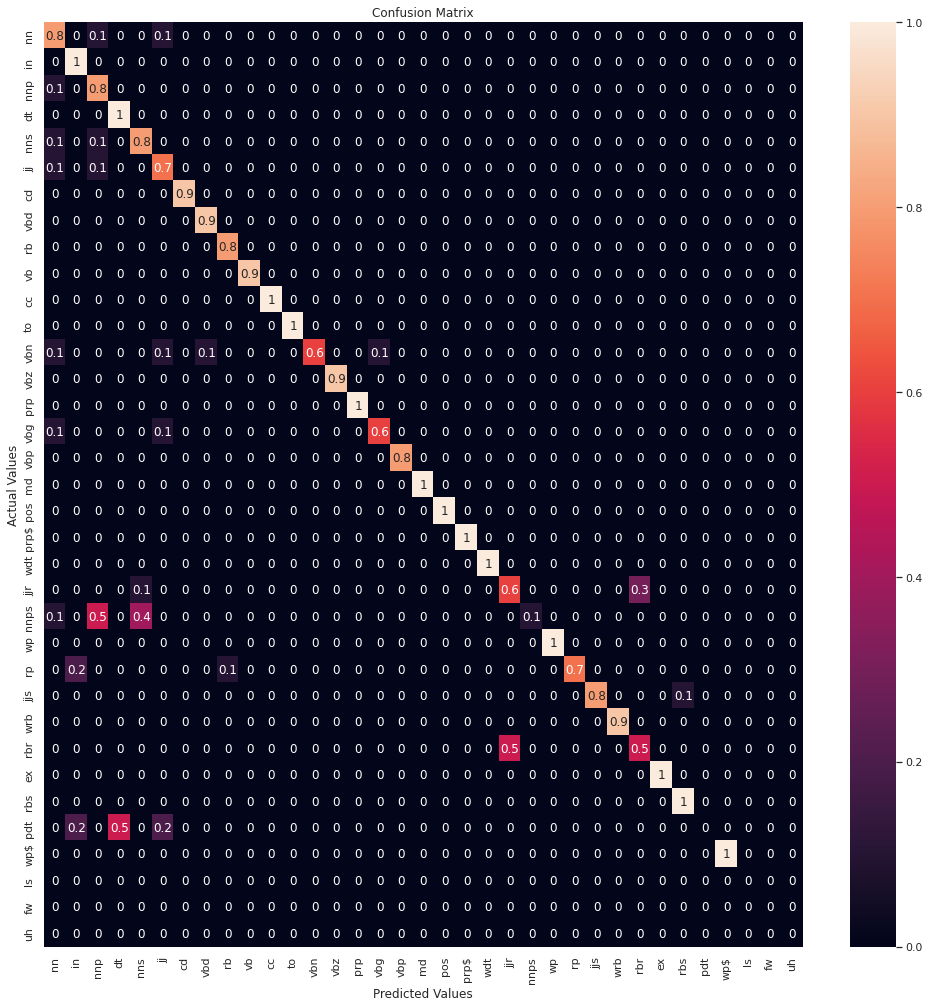

In [ ]:
plot_confusion_matrix(y_test.flatten(), y_preds[0].flatten(), labels = allowed_tokens, class_names = allowed_classes, normalize = 'true')

### Confusion Matrix - 2nd best Model

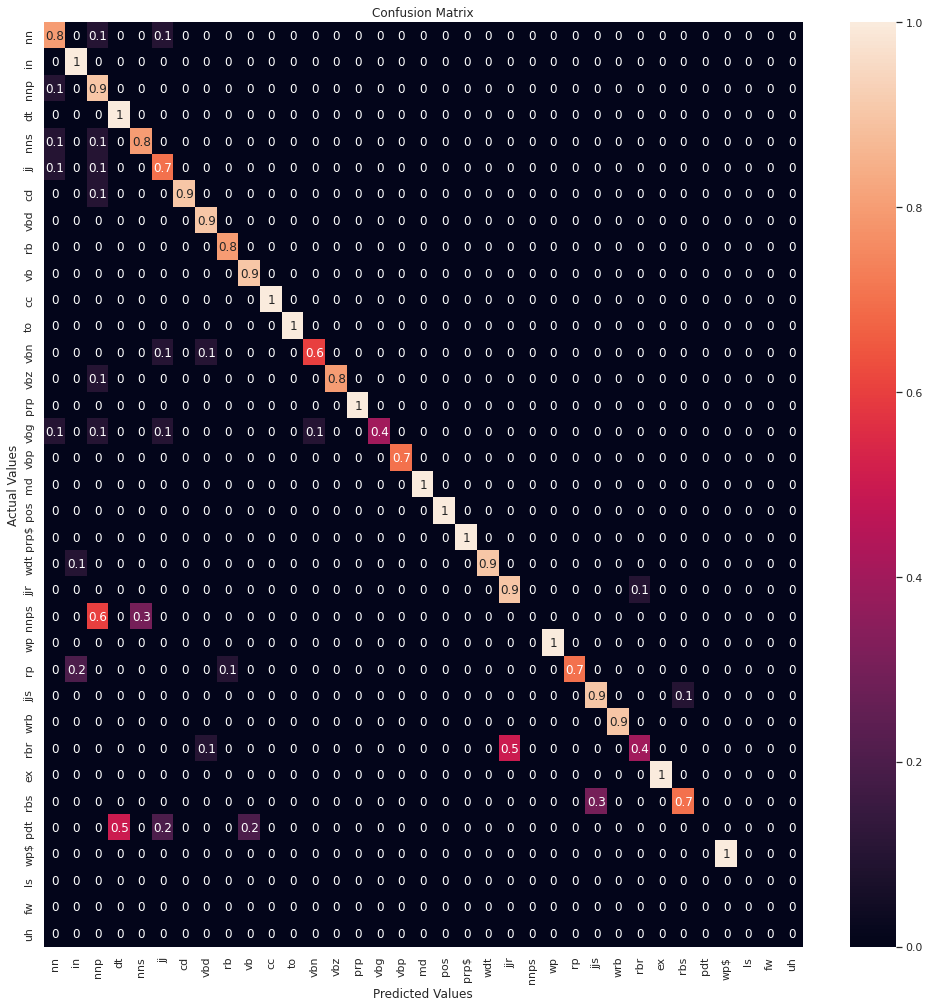

In [ ]:
plot_confusion_matrix(y_test.flatten(), y_preds[1].flatten(), labels = allowed_tokens, class_names = allowed_classes, normalize = 'true')

## Visualize Sentences

So that we can better understand where the model makes errors most, we made sure to **rank the sentences in the test set according to their f1 score and accuracy**. We noticed that models have difficulty classifying the following sentences:

* "*grains and soybeans:*"
* "*dow jones industrials 2645.90, up 0.82; transportation 1206.26, up 1.25; utilities 220.45, up 1.26.*"
* "*dollar: 143.80 yen, up 0.95; 1.8500 marks, up 0.0085*"

The errors most commonly found in sentences with the worst f1 score are:
* models think they are faced with **singular words instead they are plural**
* models **fail to detect cardinal numbers**

In [ ]:
def get_error_senteces_df(y_pred, results_model):
  error_sentences = []
  for r in range(len(results_model)):
    f1 = f1_score(y_test[r], y_pred[r], labels = allowed_tokens, average = 'micro', zero_division = 1)
    accuracy = accuracy_score(y_test[r], y_pred[r])
    real_sentence = " ".join(test.iloc[r][0])
    result = results_model[r]
    single_y_val = " ".join(test["tag"].iloc[r]).lower()

    error_sentences.append([real_sentence, result, single_y_val, f1, accuracy])

  error_sentences = pd.DataFrame(error_sentences)
  error_sentences.columns =['Real Sentences', 'Results', 'y_val', "f1_score" , "accuracy"]
  return error_sentences

error_sentences1 = get_error_senteces_df(y_preds[0], results[0])
error_sentences2 = get_error_senteces_df(y_preds[1], results[1])

### Sentence Anlysis - 1st best Model

#### Visualize Sentences by f1_score

In [ ]:
error_sentences1.sort_values(by=["f1_score"])[['Real Sentences', 'f1_score']].head(10)

,Real Sentences,f1_score
87,grains and soybeans :,0.000000
90,continued export demand also supported prices .,0.333333
193,"volume totaled 11,390,000 shares .",0.500000
365,"stocks : volume 154,240,000 shares .",0.500000
298,"south africa accused armed namibian nationalist guerrillas of crossing from bases in neighboring angola , violating u.n.-supervised peace plans for the territory 's independence from pretoria .",0.511628
419,"interleukin-3 may help in treating blood cell deficiencies associated with cancer treatment , bone marrow transplants and other blood-cell disorders , genetics institute said .",0.523810
207,"nissan scheduled a seven-yen interim dividend payment , unchanged .",0.533333
333,per-share net rose to 7.84 yen from 6.53 yen .,0.555556
369,"dollar : 143.80 yen , up 0.95 ; 1.8500 marks , up 0.0085 .",0.555556
539,"its cereal division realized higher operating profit on volume increases , but also spent more on promotion .",0.562500


#### Visualize Sentences by accuracy

In [ ]:
error_sentences1.sort_values(by=["accuracy"])[['Real Sentences', 'accuracy']].head(10)

,Real Sentences,accuracy
298,"south africa accused armed namibian nationalist guerrillas of crossing from bases in neighboring angola , violating u.n.-supervised peace plans for the territory 's independence from pretoria .",0.750000
496,"absorbed in doling out `` feeding frenzy 's '' tidbits , the authors gloss over the root causes of wedtech , namely the section 8 -lrb- a -rrb- federal program under whose auspices the scandal took place .",0.750000
313,"pan am has subpoenaed several government agencies , including the cia and fbi , to determine whether they were warned that a bomb had been planted aboard a jet that exploded over scotland last december , killing 270 people .",0.767857
550,the soviet purchases are so massive that exporters are struggling to find enough river barges and trains to move the recently harvested midwest crop to ports for loading onto soviet ships .,0.767857
576,"although u.s. corn stockpiles shrank by roughly half in the wake of the drought , the agriculture department projects that nearly one-fifth of the harvest will still be in storage before the 1990 corn harvest begins .",0.785714
498,programs like section 8 -lrb- a -rrb- are a little like leaving gold in the street and then expressing surprise when thieves walk by to scoop it up .,0.785714
419,"interleukin-3 may help in treating blood cell deficiencies associated with cancer treatment , bone marrow transplants and other blood-cell disorders , genetics institute said .",0.803571
481,"starting with congressman mario biaggi -lrb- now serving a jail sentence -rrb- , the company began a career of bribing federal , state and local public officials and those close to public officials , right up to and including e. robert wallach , close friend and adviser to former attorney general ed meese .",0.803571
472,"bribe by bribe , mr. sternberg and his co-author , matthew c. harrison jr. , lead us along the path wedtech traveled , from its inception as a small manufacturing company to the status of full-fledged defense contractor , entrusted with the task of producing vital equipment for the army and navy .",0.803571
628,"still , usx fared better than other major steelmakers , earning more per ton of steel shipped than either bethlehem steel corp. , which posted a 54 % drop in net income , or inland steel industries inc. , whose profit plummeted 70 % .",0.803571


#### Visualize Single Sentence

In [ ]:
elem = 90

print(f'True Sentence:\n{" ".join(test.iloc[elem][0])}\n')
#print(f'Sentence:\n{tokenized_text[elem]}\n')
print(f'Results:\n{results[0][elem]}\n')
print(f'y_val:\n{" ".join(test["tag"].iloc[elem]).lower()}')

True Sentence:
continued export demand also supported prices .

Results:
in nn nns in jj nns .

y_val:
vbn nn nn rb vbd nns .


### Sentence Anlysis - 2st best Model

#### Visualize Sentences by f1_score

In [ ]:
error_sentences2.sort_values(by=["f1_score"])[['Real Sentences', 'f1_score']].head(10)

,Real Sentences,f1_score
87,grains and soybeans :,0.000000
369,"dollar : 143.80 yen , up 0.95 ; 1.8500 marks , up 0.0085 .",0.222222
366,"dow jones industrials 2645.90 , up 0.82 ; transportation 1206.26 , up 1.25 ; utilities 220.45 , up 1.26 .",0.285714
368,"commodities : dow jones futures index 129.91 , up 0.28 ; spot index 131.01 , up 1.17 .",0.307692
230,rms distributes electronic devices and produces power supplies and plastic literature displays .,0.416667
298,"south africa accused armed namibian nationalist guerrillas of crossing from bases in neighboring angola , violating u.n.-supervised peace plans for the territory 's independence from pretoria .",0.480000
410,business : savings and loan,0.500000
333,per-share net rose to 7.84 yen from 6.53 yen .,0.555556
490,none of the scams show much ingenuity : auditors found crookery the first day on the job .,0.562500
192,the american stock exchange market value index gained 1.56 to 372.14 .,0.571429


#### Visualize Sentences by accuracy

In [ ]:
error_sentences2.sort_values(by=["accuracy"])[['Real Sentences', 'accuracy']].head(10)

,Real Sentences,accuracy
481,"starting with congressman mario biaggi -lrb- now serving a jail sentence -rrb- , the company began a career of bribing federal , state and local public officials and those close to public officials , right up to and including e. robert wallach , close friend and adviser to former attorney general ed meese .",0.732143
496,"absorbed in doling out `` feeding frenzy 's '' tidbits , the authors gloss over the root causes of wedtech , namely the section 8 -lrb- a -rrb- federal program under whose auspices the scandal took place .",0.750000
298,"south africa accused armed namibian nationalist guerrillas of crossing from bases in neighboring angola , violating u.n.-supervised peace plans for the territory 's independence from pretoria .",0.767857
550,the soviet purchases are so massive that exporters are struggling to find enough river barges and trains to move the recently harvested midwest crop to ports for loading onto soviet ships .,0.785714
171,"other rumored takeover and restructuring candidates to attract buyers included woolworth , which went up 1 3\/4 to 59 1\/2 ; avon products , up 1 3\/4 to 29 1\/4 ; paramount communications , up 2 to 57 7\/8 , and ferro , up 2 5\/8 to 28 3\/4 .",0.785714
472,"bribe by bribe , mr. sternberg and his co-author , matthew c. harrison jr. , lead us along the path wedtech traveled , from its inception as a small manufacturing company to the status of full-fledged defense contractor , entrusted with the task of producing vital equipment for the army and navy .",0.803571
183,"mead rose 3\/4 to 39 1\/2 , federal paper board added 1\/2 to 24 3\/8 and scott paper gained 1\/2 to 48 3\/8 , while international paper fell 7\/8 to 48 7\/8 , champion international lost 3\/8 to 31 1\/2 and louisiana-pacific dropped 1\/8 to 40 1\/4 .",0.803571
628,"still , usx fared better than other major steelmakers , earning more per ton of steel shipped than either bethlehem steel corp. , which posted a 54 % drop in net income , or inland steel industries inc. , whose profit plummeted 70 % .",0.821429
498,programs like section 8 -lrb- a -rrb- are a little like leaving gold in the street and then expressing surprise when thieves walk by to scoop it up .,0.821429
337,"komatsu predicted that for the fiscal year ending march 31 sales will climb to 600 billion yen from 566.54 billion yen ; pretax profit was forecast at 35 billion yen , up from 28.53 billion yen in fiscal 1989 .",0.821429


#### Visualize Single Sentence

In [ ]:
elem = 87

print(f'True Sentence:\n{" ".join(test.iloc[elem][0])}\n')
#print(f'Sentence:\n{tokenized_text[elem]}\n')
print(f'Results:\n{results[1][elem]}\n')
print(f'y_val:\n{" ".join(test["tag"].iloc[elem]).lower()}')

True Sentence:
grains and soybeans :

Results:
nnp cc nnp :

y_val:
nnps nnp nnps :


## Plot Sentences by length

Here we tried to understand **how sentence length could affect performance**. The correlation is not very obvious so we just assume it is a statistical error (the greater the amount of words to predict, the greater the probability of making an error).

In [ ]:
#Here we tried to understand how word length could affect performance.
#The correlation is not very obvious so we just assume it is a statistical error
#(the greater the amount of words to predict, the greater the probability of making an error).

def obt_len(value):
  return len(value.split(" "))

lens = error_sentences1["Real Sentences"].apply(obt_len).to_numpy()

### Plot Sentences by length - 1st best Model

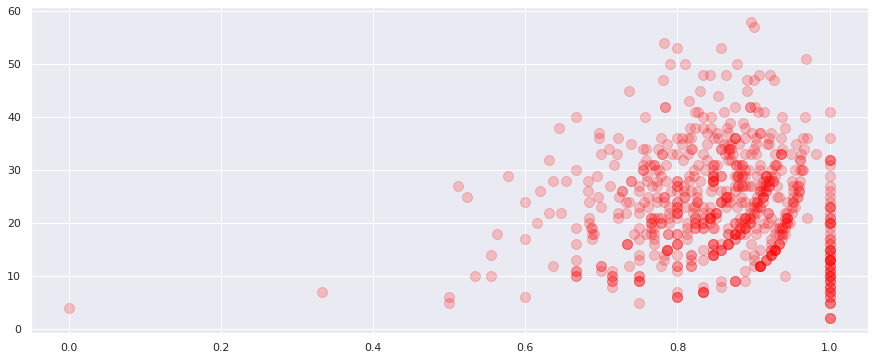

In [ ]:
plt.plot(error_sentences1['f1_score'].to_numpy(), lens, 'o', color='red', alpha = 0.2, markersize = 10)

### Plot Sentences by length - 2st best Model

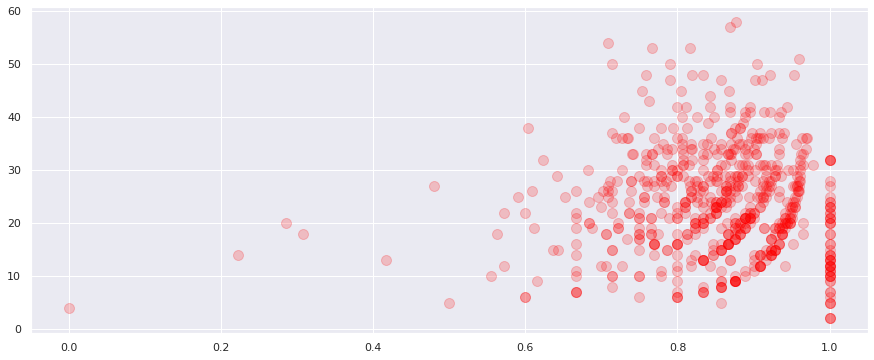

In [ ]:
plt.plot(error_sentences2['f1_score'].to_numpy(), lens, 'o', color='red', alpha = 0.2, markersize = 10)

## Plot Sentences by UNK - F1 Score

Plotting a **graph that relates the number of UNK word and the f1 score associated with the sentence** helps understanding whether the two aspects are **correlated or not**.

In [ ]:
def get_unk_df(results, y_pred):
  unk_df = []
  for r in range(len(results)):
    f1 = f1_score(y_test[r], y_pred[r], labels = allowed_tokens, average = 'macro', zero_division = 1)
    unk_numb = test['ohe'].to_numpy()[r].count(1) #count number of unknown

    unk_df.append([f1, unk_numb])
  return unk_df

### Plot UNK-F1 - 1st best Model

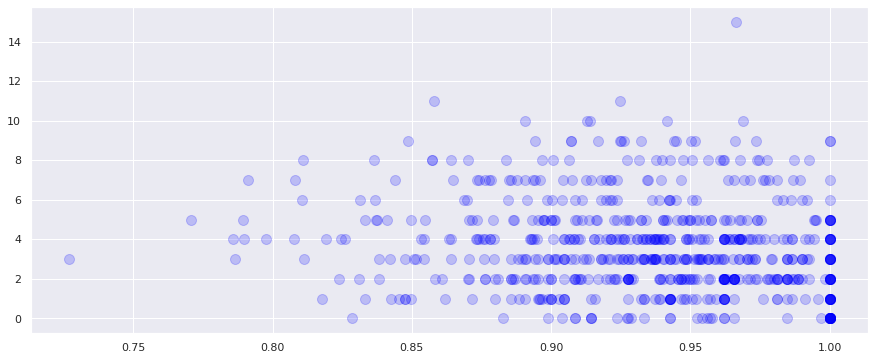

In [ ]:
unk_df1 = get_unk_df(results[0],y_preds[0])
plt.plot(np.transpose(unk_df1)[0], np.transpose(unk_df1)[1], 'o', color='blue', alpha = 0.2, markersize = 10)

### Plot UNK-F1 - 2st best Model

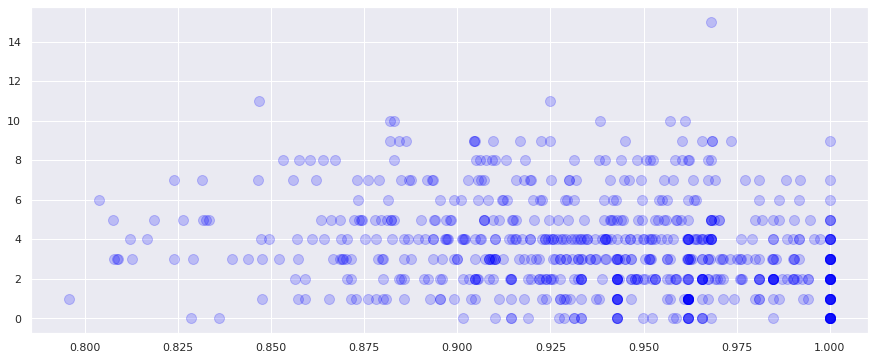

In [ ]:
unk_df1 = get_unk_df(results[1],y_preds[1])
plt.plot(np.transpose(unk_df1)[0], np.transpose(unk_df1)[1], 'o', color='blue', alpha = 0.2, markersize = 10)

## Plot Missclassified Words

It might be helpful to plot the **words that led most to mistakes**.

Some of the **most missclassified words** are: "UNK", "up", "yen", and "that". To better understand why, we plotted the **graph that allows you to see which tags associated with that word the model guessed and which ones it did not**. We also decided to **check what is the distribution within the training set regarding the tags associated with that particular word**. In general we can say that the two graphs are similar, all the way **the model usually learns better to associate a single tag with a given word using less of the others**.

It may be useful to visualize what the most common errors are considering an overall view of the test set. As we can see from the table below, our model is easily confusing:

* **Adjective** with **Preposition or subordinating conjunction**
* **Preposition or subordinating conjunction** with **Determiner** and viceversa
* **Adjective** with **Determiner**

More generally, we can say that the model **struggles with these three tags**.


In [ ]:
#get missclassified position

def get_word_misscls(y_pred):
  word_misscls = []

  for i in range(len(y_test.flatten())):
    if y_test.flatten()[i] != y_pred.flatten()[i]:
      word_misscls.append([x_test.flatten()[i], tokenizer.tokenizer.index_word[x_test.flatten()[i]],
                          all_classes[y_pred.flatten()[i]], all_classes[y_test.flatten()[i]]])

  word_misscls = pd.DataFrame(word_misscls, columns = ['token', 'word', 'predicted tag', 'correct tag'])
  return word_misscls

### Missclassification - 1st Best Model
Understandably, the most **missclassified word is Unknown**, followed by words that depend very much on the context of the sentence and are used very often.

In [ ]:
word_misscls1 = get_word_misscls(y_preds[0])
word_misscls1['word'].value_counts().to_frame().head(10)

,word
UNK,1010
up,24
that,19
yen,14
fiscal,12
more,11
-rrb-,10
earlier,9
first,9
operations,9


#### Plot single word tag distribution

In [ ]:
def fill_zero_missing_tokens(dist, tokens):
  new_dist = []
  actual_pos = 0
  for token in tokens:
    if token in dist[0]:
      new_dist.append(dist[1][actual_pos])
      actual_pos += 1
    else:
      new_dist.append(0)

  return new_dist

In [ ]:
word_to_plot = 'up' #'UNK'
token_to_plot = tokenizer.tokenizer.word_index[word_to_plot]

##### Test set

In [ ]:
correct_tags_of_word_to_plot = [yt for yt, yp, xt
                                in zip(y_test.flatten(), y_preds[0].flatten(), x_test.flatten()) 
                                if yt == yp and token_to_plot == xt]
dist_correct_word = fill_zero_missing_tokens(np.unique(correct_tags_of_word_to_plot, return_counts=True), allowed_tokens)

wrong_tags_of_word_to_plot = [yt for yt, yp, xt
                                in zip(y_test.flatten(), y_preds[0].flatten(), x_test.flatten()) 
                                if yt != yp and token_to_plot == xt]
dist_wrong_word = fill_zero_missing_tokens(np.unique(wrong_tags_of_word_to_plot, return_counts=True), allowed_tokens)

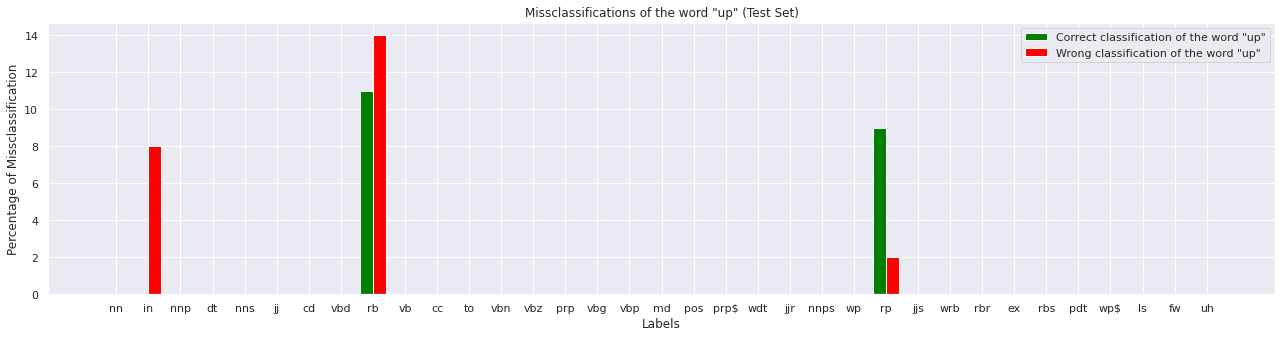

In [ ]:
plot_dists(dist1 = dist_correct_word, dist2 = dist_wrong_word, 
            tokens = allowed_tokens, class_names = allowed_classes, 
            title = "Missclassifications of the word \"" + word_to_plot + "\" (Test Set)",
            y_title = "Percentage of Missclassification",
            dist1_title = "Correct classification of the word \"" + word_to_plot + "\"",
            dist2_title = "Wrong classification of the word \"" + word_to_plot + "\"")

##### Training set

In [ ]:
train_tags_of_word_to_plot = [yt for yt, xt
                                in zip(y_train.argmax(-1).flatten(), x_train.flatten()) 
                                if token_to_plot == xt]
dist_train_word = fill_zero_missing_tokens(np.unique(train_tags_of_word_to_plot, return_counts=True), allowed_tokens)

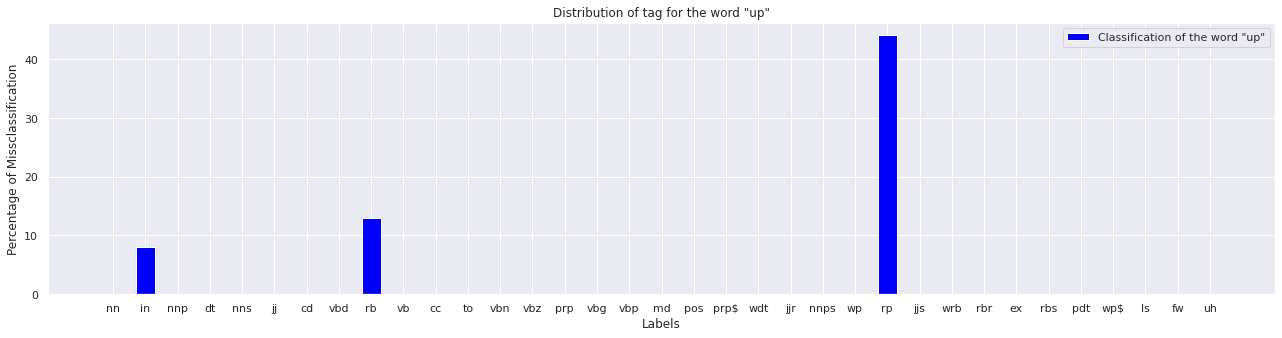

In [ ]:
plot_dists(dist1 = dist_train_word, 
           tokens = allowed_tokens, class_names = allowed_classes, 
           title = "Distribution of tag for the word \"" + word_to_plot + "\"",
           y_title = "Percentage of Missclassification",
           dist1_title = "Classification of the word \"" + word_to_plot + "\"")

#### Common Errors

In [ ]:
word_misscls1.groupby(['predicted tag', 'correct tag']).size().sort_values(ascending=False).reset_index(name='count').head(10)

,predicted tag,correct tag,count
0,dt,in,146
1,in,",",131
2,",",in,129
3,in,dt,128
4,in,jj,98
5,dt,",",65
6,jj,in,59
7,",",dt,57
8,dt,jj,47
9,",",vbz,46


### Missclassification - 2st Best Model
Understandably, the most **missclassified word is Unknown**, followed by words that depend very much on the context of the sentence and are used very often.

In [ ]:
word_misscls2 = get_word_misscls(y_preds[1])
word_misscls2['word'].value_counts().to_frame().head(10)

,word
UNK,971
yen,22
that,17
up,17
as,11
-rrb-,11
operating,11
about,10
fiscal,10
third-quarter,8


#### Plot single word tag distribution

In [ ]:
def fill_zero_missing_tokens(dist, tokens):
  new_dist = []
  actual_pos = 0
  for token in tokens:
    if token in dist[0]:
      new_dist.append(dist[1][actual_pos])
      actual_pos += 1
    else:
      new_dist.append(0)

  return new_dist

In [ ]:
#word_to_plot = 'UNK'
word_to_plot = 'up'
token_to_plot = tokenizer.tokenizer.word_index[word_to_plot]

##### Test set

In [ ]:
correct_tags_of_word_to_plot = [yt for yt, yp, xt
                                in zip(y_test.flatten(), y_preds[1].flatten(), x_test.flatten()) 
                                if yt == yp and token_to_plot == xt]
dist_correct_word = fill_zero_missing_tokens(np.unique(correct_tags_of_word_to_plot, return_counts=True), allowed_tokens)

wrong_tags_of_word_to_plot = [yt for yt, yp, xt
                                in zip(y_test.flatten(), y_preds[1].flatten(), x_test.flatten()) 
                                if yt != yp and token_to_plot == xt]
dist_wrong_word = fill_zero_missing_tokens(np.unique(wrong_tags_of_word_to_plot, return_counts=True), allowed_tokens)

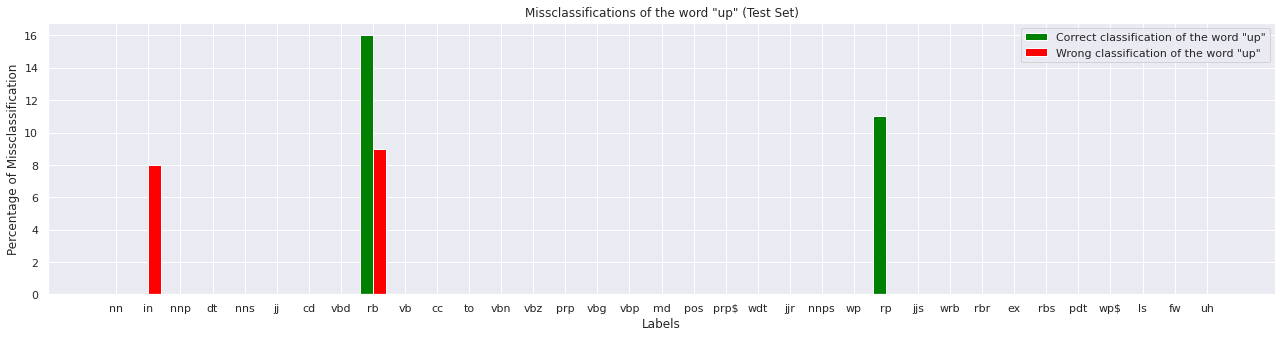

In [ ]:
plot_dists(dist1 = dist_correct_word, dist2 = dist_wrong_word, 
            tokens = allowed_tokens, class_names = allowed_classes, 
            title = "Missclassifications of the word \"" + word_to_plot + "\" (Test Set)",
            y_title = "Percentage of Missclassification",
            dist1_title = "Correct classification of the word \"" + word_to_plot + "\"",
            dist2_title = "Wrong classification of the word \"" + word_to_plot + "\"")

##### Training set

In [ ]:
train_tags_of_word_to_plot = [yt for yt, xt
                                in zip(y_train.argmax(-1).flatten(), x_train.flatten()) 
                                if token_to_plot == xt]
dist_train_word = fill_zero_missing_tokens(np.unique(train_tags_of_word_to_plot, return_counts=True), allowed_tokens)

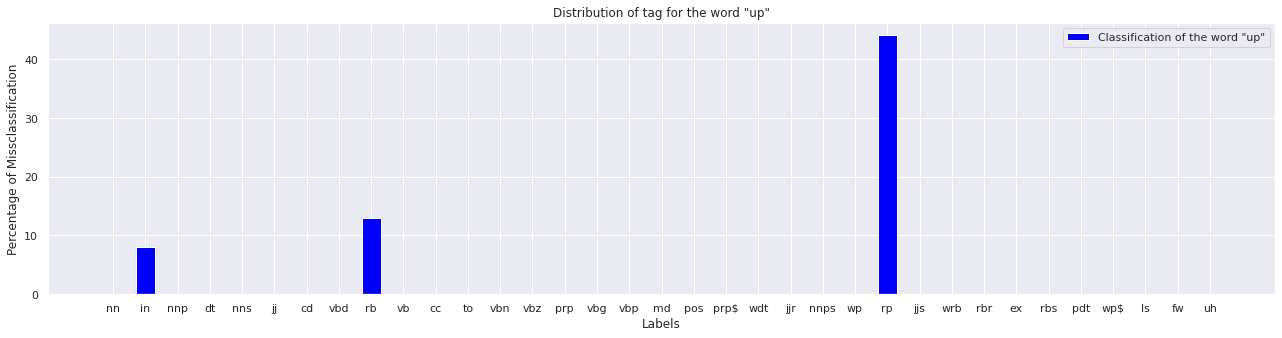

In [ ]:
plot_dists(dist1 = dist_train_word, 
           tokens = allowed_tokens, class_names = allowed_classes, 
           title = "Distribution of tag for the word \"" + word_to_plot + "\"",
           y_title = "Percentage of Missclassification",
           dist1_title = "Classification of the word \"" + word_to_plot + "\"")

#### Common Errors

In [ ]:
word_misscls2.groupby(['predicted tag', 'correct tag']).size().sort_values(ascending=False).reset_index(name='count').head(10)

,predicted tag,correct tag,count
0,dt,in,228
1,",",in,162
2,dt,",",112
3,in,",",91
4,in,dt,91
5,in,jj,91
6,dt,jj,89
7,",",dt,67
8,dt,vbd,54
9,jj,in,49
